In [2]:
# Data processing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# LSTM model for time series forecasting
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Data scaling
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Load each dataset with the correct file paths
train_df = pd.read_csv("C:/Users/egeme/OneDrive/Masaüstü/NeWProjectS/Walmart-LSTMmodel/Data/train.csv")
test_df = pd.read_csv("C:/Users/egeme/OneDrive/Masaüstü/NeWProjectS/Walmart-LSTMmodel/Data/test.csv")
features_df = pd.read_csv("C:/Users/egeme/OneDrive/Masaüstü/NeWProjectS/Walmart-LSTMmodel/Data/features.csv")
stores_df = pd.read_csv("C:/Users/egeme/OneDrive/Masaüstü/NeWProjectS/Walmart-LSTMmodel/Data/stores.csv")

In [4]:
# Display the first few rows of each dataset to understand their structure
print("Train Data")
print(train_df.head())
print(train_df.info())

print("\nTest Data")
print(test_df.head())
print(test_df.info())

print("\nFeatures Data")
print(features_df.head())
print(features_df.info())

print("\nStores Data")
print(stores_df.head())
print(stores_df.info())

Train Data
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB
None

Test Data
   Store  Dept        Date  IsHoliday
0      1     1  2012-11-02      False
1      1     1  2012-11-09      False
2      1     1  2012-11-16      False
3      1     1  201

In [5]:
# Convert 'Date' column to datetime format
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])
features_df['Date'] = pd.to_datetime(features_df['Date'])

# Merge train data with features and stores data on 'Store' and 'Date' columns
train_merged = train_df.merge(features_df, on=['Store', 'Date'], how='left')
train_merged = train_merged.merge(stores_df, on='Store', how='left')

In [6]:
# Fill missing values with 0
train_merged.fillna(0, inplace=True)

In [7]:
# Select relevant features for scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(train_merged[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']])

In [8]:
# Prepare data for LSTM model: using past 30 days to predict the next day's sales
X, y = [], []
sequence_length = 30
for i in range(sequence_length, len(scaled_features)):
    X.append(scaled_features[i-sequence_length:i])  # Past 30 days data as input
    y.append(scaled_features[i, 0])  # 'Weekly_Sales' as the target for the next day

In [9]:
# Display summary statistics for numerical columns in each dataframe
print("Train Data Summary")
print(train_df.describe())

print("\nFeatures Data Summary")
print(features_df.describe())

print("\nStores Data Summary")
print(stores_df.describe())


Train Data Summary
               Store           Dept                           Date  \
count  421570.000000  421570.000000                         421570   
mean       22.200546      44.260317  2011-06-18 08:30:31.963375104   
min         1.000000       1.000000            2010-02-05 00:00:00   
25%        11.000000      18.000000            2010-10-08 00:00:00   
50%        22.000000      37.000000            2011-06-17 00:00:00   
75%        33.000000      74.000000            2012-02-24 00:00:00   
max        45.000000      99.000000            2012-10-26 00:00:00   
std        12.785297      30.492054                            NaN   

        Weekly_Sales  
count  421570.000000  
mean    15981.258123  
min     -4988.940000  
25%      2079.650000  
50%      7612.030000  
75%     20205.852500  
max    693099.360000  
std     22711.183519  

Features Data Summary
             Store                 Date  Temperature   Fuel_Price  \
count  8190.000000                 8190  8190.00000

In [10]:
# Check for missing values in each dataframe
print("Missing values in train data:\n", train_df.isnull().sum())
print("Missing values in features data:\n", features_df.isnull().sum())
print("Missing values in stores data:\n", stores_df.isnull().sum())


Missing values in train data:
 Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64
Missing values in features data:
 Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64
Missing values in stores data:
 Store    0
Type     0
Size     0
dtype: int64


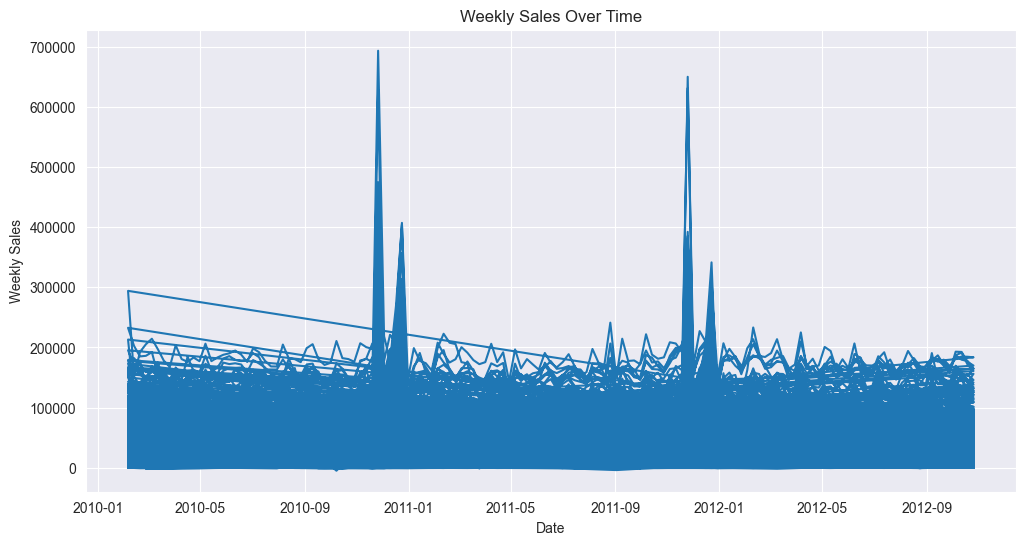

In [11]:
import matplotlib.pyplot as plt

# Plot weekly sales over time to check for seasonal trends and patterns
plt.figure(figsize=(12, 6))
plt.plot(train_df['Date'], train_df['Weekly_Sales'])
plt.title("Weekly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.show()


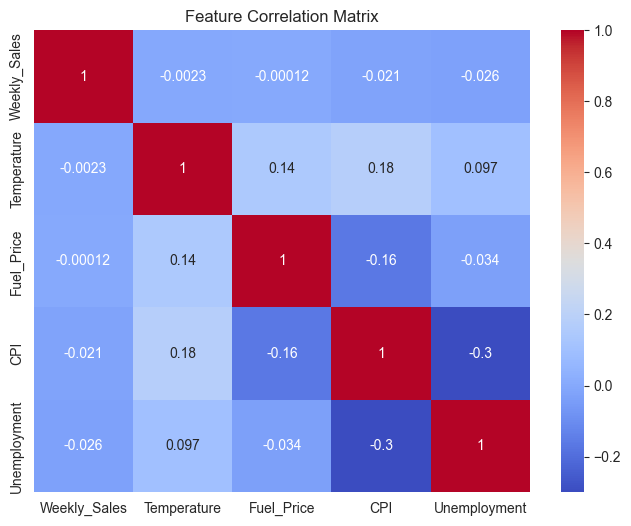

In [12]:
import seaborn as sns

# Calculate correlation matrix for merged train data
corr_matrix = train_merged[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()


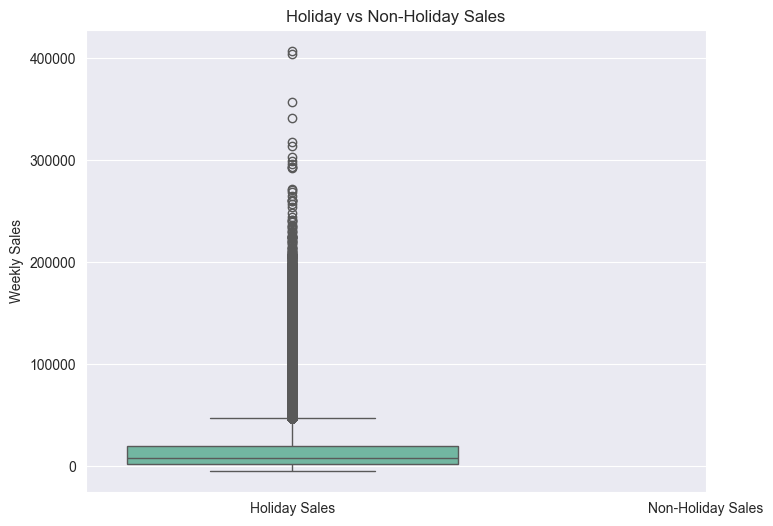

In [13]:
# Check the effect of holidays on sales
holiday_sales = train_df[train_df['IsHoliday'] == True]['Weekly_Sales']
non_holiday_sales = train_df[train_df['IsHoliday'] == False]['Weekly_Sales']

# Plot holiday vs non-holiday sales
plt.figure(figsize=(8, 6))
sns.boxplot(data=[holiday_sales, non_holiday_sales], palette="Set2")
plt.xticks([0, 1], ["Holiday Sales", "Non-Holiday Sales"])
plt.ylabel("Weekly Sales")
plt.title("Holiday vs Non-Holiday Sales")
plt.show()


# Weekly Sales Analysis

### 1. Weekly Sales Over Time
- There are notable peaks and troughs in weekly sales, with significant spikes during holiday periods.
- These peaks indicate important factors such as **seasonality** and **holiday effects** that should be considered in the sales forecasting model.
- Holidays should be factored separately when forecasting sales.

---

### 2. Correlation Matrix
- There is no strong direct correlation observed between **Weekly Sales** and other variables, indicating that other features may not have a direct impact on sales.
- However, economic or weather-related factors like **Fuel Price** and **Temperature** may have indirect effects.
- This suggests that **feature engineering** could capture indirect effects, potentially improving model performance.

---

### 3. Holiday vs. Non-Holiday Sales
- A clear difference in sales between holiday and non-holiday periods is observed.
- High spikes in sales during holidays indicate that the holiday effect is significant and should be considered in the model.
- Including **holiday-related features** in the model could enhance the understanding of holiday impacts on sales.

---

### 4. Missing Data Analysis
- There are several missing values in the **MarkDown** columns.
  - Missing values in these columns could be treated as non-promotional periods and filled with 0.
  - Alternatively, missing values can be filled with **mean/median** values or the MarkDown columns can be excluded from the model if necessary.
- Economic indicators like **CPI (Consumer Price Index)** and **Unemployment** also have some missing data.
  - These missing values can be filled using time-series interpolation methods such as linear interpolation, or these features can be excluded from certain models.

---

### 5. Statistical Summary of Data
- Negative values exist in the **Weekly Sales** column, which may represent returns or cancellations.
  - The meaning of these negative values should be carefully evaluated in the modeling process, and data cleaning or special processing might be necessary.
- The **MarkDown** columns have high standard deviations, reflecting variability in promotional amounts.
  - The impact of this variability should be considered in modeling, and the contribution of these features should be analyzed.

---

### Key Points to Consider in the Model:
1. Create **new features** to capture seasonality and holiday effects.
2. Handle missing values effectively and apply data exclusion strategies where necessary.
3. Add **data cleaning** steps to address negative values and ensure data integrity.


In [14]:
# Convert 'Date' to datetime format
train_df['Date'] = pd.to_datetime(train_df['Date'])

# Extract year, month, and day of the week
train_df['Year'] = train_df['Date'].dt.year
train_df['Month'] = train_df['Date'].dt.month
train_df['DayOfWeek'] = train_df['Date'].dt.dayofweek


In [15]:
# This is already available in the data as 'IsHoliday' 
# Ensure it’s in a binary format (if needed)
train_df['IsHoliday'] = train_df['IsHoliday'].astype(int)


In [16]:
# 4-week, 8-week, and 12-week moving averages for weekly sales
train_df['WeeklySales_MA_4'] = train_df['Weekly_Sales'].rolling(window=4).mean()
train_df['WeeklySales_MA_8'] = train_df['Weekly_Sales'].rolling(window=8).mean()
train_df['WeeklySales_MA_12'] = train_df['Weekly_Sales'].rolling(window=12).mean()


In [17]:
# Lag features: previous 1 and 2 weeks of sales
train_df['WeeklySales_Lag_1'] = train_df['Weekly_Sales'].shift(1)
train_df['WeeklySales_Lag_2'] = train_df['Weekly_Sales'].shift(2)


In [19]:
print(features_df.columns)


Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday'],
      dtype='object')


In [20]:
# Fill missing values in MarkDown columns in features_df
features_df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']] = features_df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].fillna(0)

# Alternatively, fill with median
# features_df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']] = features_df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].fillna(features_df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].median())


In [23]:

features_df['CPI'] = features_df['CPI'].ffill()
features_df['Unemployment'] = features_df['Unemployment'].ffill()


In [25]:
# Check available columns in each DataFrame
print("Columns in train_df:", train_df.columns)
print("Columns in features_df:", features_df.columns)


Columns in train_df: Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Year', 'Month',
       'DayOfWeek', 'WeeklySales_MA_4', 'WeeklySales_MA_8',
       'WeeklySales_MA_12', 'WeeklySales_Lag_1', 'WeeklySales_Lag_2'],
      dtype='object')
Columns in features_df: Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday'],
      dtype='object')


In [26]:
# Calculate weekly fuel price change percentage
features_df['FuelPrice_Change'] = features_df['Fuel_Price'].pct_change()


In [27]:
# Lagged CPI and Unemployment features
features_df['CPI_Lag_1'] = features_df['CPI'].shift(1)
features_df['Unemployment_Lag_1'] = features_df['Unemployment'].shift(1)


In [30]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Instantiate separate scalers for each DataFrame
scaler_train = MinMaxScaler()  
scaler_features = MinMaxScaler()

# Columns to scale in train_df
train_df_cols_to_scale = ['Weekly_Sales', 'WeeklySales_MA_4', 'WeeklySales_MA_8', 'WeeklySales_MA_12', 'WeeklySales_Lag_1', 'WeeklySales_Lag_2']

# Columns to scale in features_df
features_df_cols_to_scale = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'FuelPrice_Change', 'CPI_Lag_1', 'Unemployment_Lag_1']

# Apply scaling separately to each DataFrame
train_df[train_df_cols_to_scale] = scaler_train.fit_transform(train_df[train_df_cols_to_scale])
features_df[features_df_cols_to_scale] = scaler_features.fit_transform(features_df[features_df_cols_to_scale])



In [31]:
# Check for missing values in train_df and features_df
print("Missing values in train_df:")
print(train_df.isnull().sum())
print("\nMissing values in features_df:")
print(features_df.isnull().sum())


Missing values in train_df:
Store                 0
Dept                  0
Date                  0
Weekly_Sales          0
IsHoliday             0
Year                  0
Month                 0
DayOfWeek             0
WeeklySales_MA_4      3
WeeklySales_MA_8      7
WeeklySales_MA_12    11
WeeklySales_Lag_1     1
WeeklySales_Lag_2     2
dtype: int64

Missing values in features_df:
Store                 0
Date                  0
Temperature           0
Fuel_Price            0
MarkDown1             0
MarkDown2             0
MarkDown3             0
MarkDown4             0
MarkDown5             0
CPI                   0
Unemployment          0
IsHoliday             0
FuelPrice_Change      1
CPI_Lag_1             1
Unemployment_Lag_1    1
dtype: int64


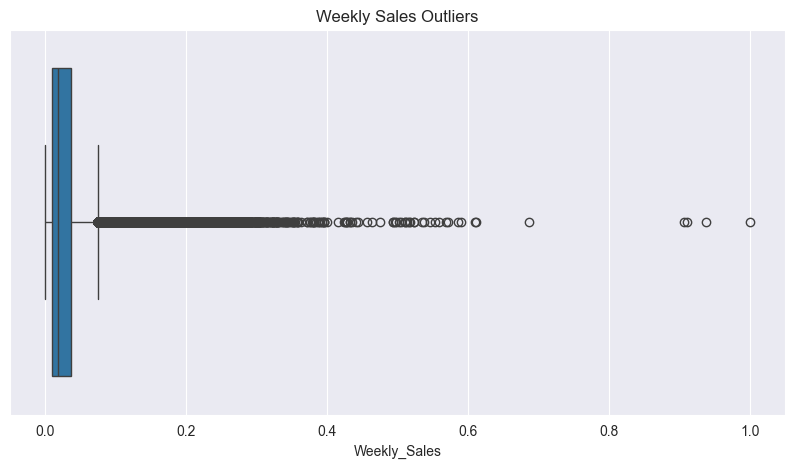

In [32]:
# Check for outliers in key columns in features_df and train_df
import matplotlib.pyplot as plt
import seaborn as sns

# Example for boxplot for 'Weekly_Sales' in train_df
plt.figure(figsize=(10, 5))
sns.boxplot(data=train_df, x='Weekly_Sales')
plt.title('Weekly Sales Outliers')
plt.show()

# Repeat similar plots for Temperature, Fuel_Price, CPI, Unemployment in features_df


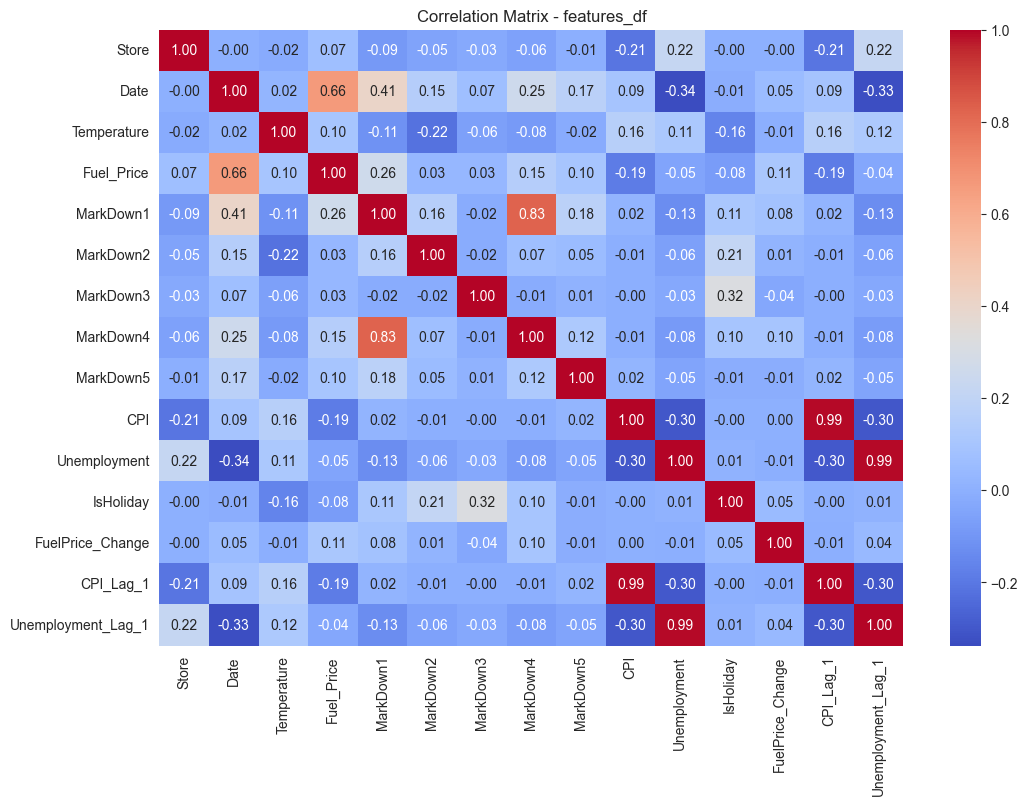

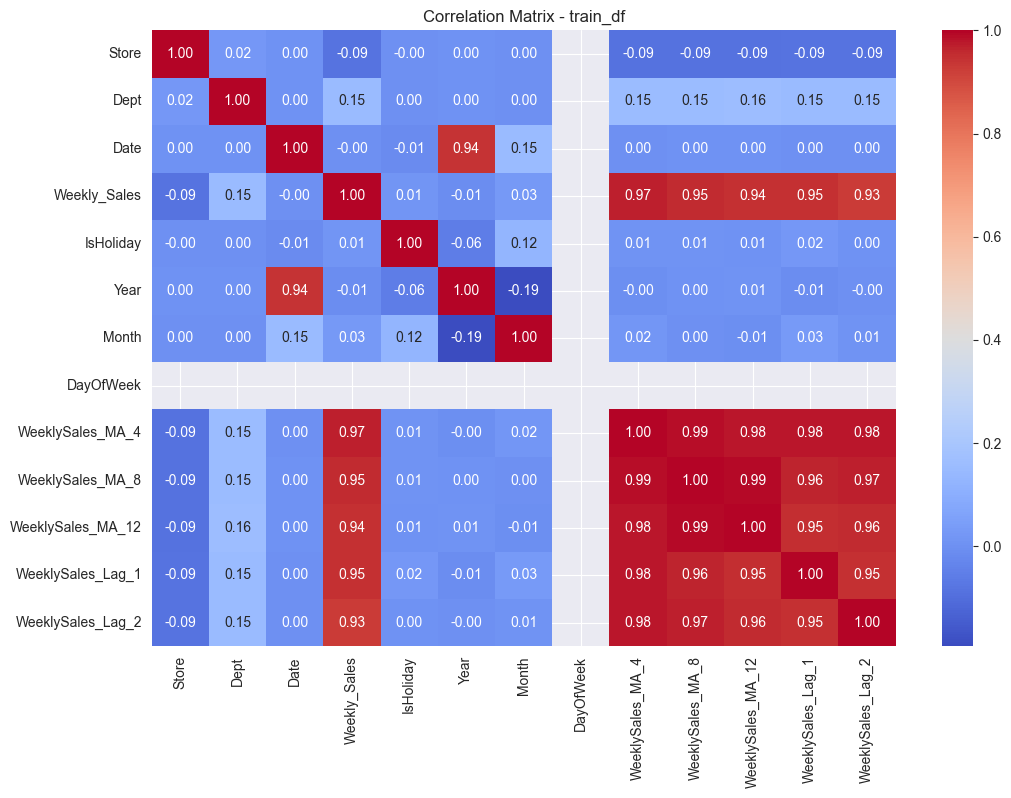

In [33]:
# Correlation matrix for features_df
plt.figure(figsize=(12, 8))
sns.heatmap(features_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix - features_df')
plt.show()

# Correlation matrix for train_df (if applicable)
plt.figure(figsize=(12, 8))
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix - train_df')
plt.show()


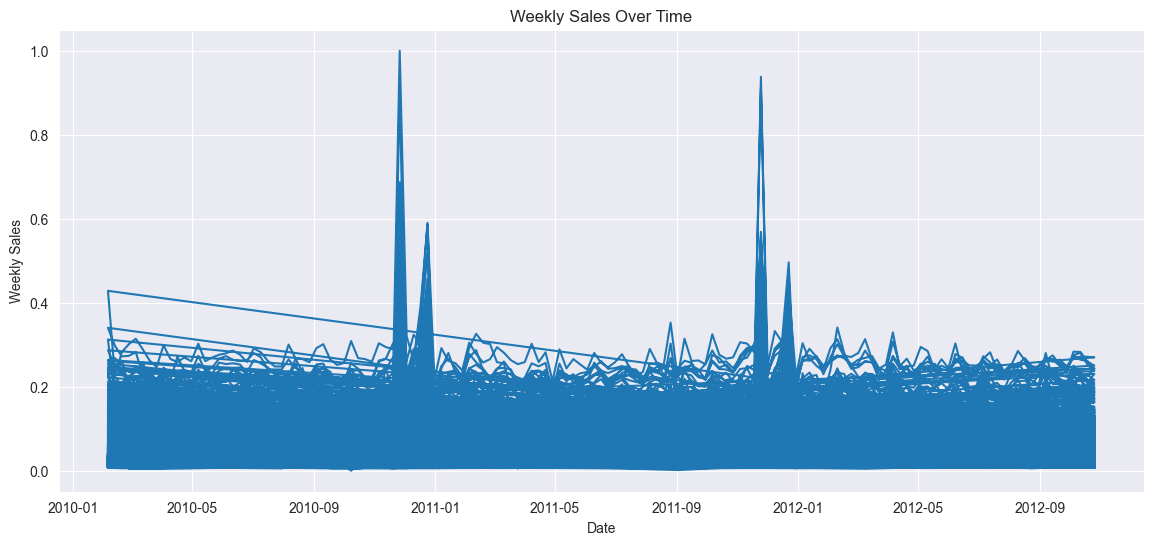

In [34]:
# Plot Weekly Sales over time to observe trend and seasonality
plt.figure(figsize=(14, 6))
plt.plot(train_df['Date'], train_df['Weekly_Sales'])
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()


In [38]:
# Fill missing values in moving averages and lag features in train_df
train_df['WeeklySales_MA_4'] = train_df['WeeklySales_MA_4'].bfill()
train_df['WeeklySales_MA_8'] = train_df['WeeklySales_MA_8'].bfill()
train_df['WeeklySales_MA_12'] = train_df['WeeklySales_MA_12'].bfill()
train_df['WeeklySales_Lag_1'] = train_df['WeeklySales_Lag_1'].bfill()
train_df['WeeklySales_Lag_2'] = train_df['WeeklySales_Lag_2'].bfill()

# Fill missing values in lagged economic indicators in features_df
features_df['FuelPrice_Change'] = features_df['FuelPrice_Change'].bfill()
features_df['CPI_Lag_1'] = features_df['CPI_Lag_1'].bfill()
features_df['Unemployment_Lag_1'] = features_df['Unemployment_Lag_1'].bfill()


In [40]:
# Fill missing values in lagged economic indicators in features_df
features_df['FuelPrice_Change'] = features_df['FuelPrice_Change'].bfill()
features_df['CPI_Lag_1'] = features_df['CPI_Lag_1'].bfill()
features_df['Unemployment_Lag_1'] = features_df['Unemployment_Lag_1'].bfill()


In [41]:
# Compare Weekly Sales for holiday vs non-holiday periods
holiday_sales = train_df[train_df['IsHoliday'] == True]['Weekly_Sales']
non_holiday_sales = train_df[train_df['IsHoliday'] == False]['Weekly_Sales']

print("Average Weekly Sales on Holidays:", holiday_sales.mean())
print("Average Weekly Sales on Non-Holidays:", non_holiday_sales.mean())


Average Weekly Sales on Holidays: 0.03155011076299429
Average Weekly Sales on Non-Holidays: 0.02992513277906014


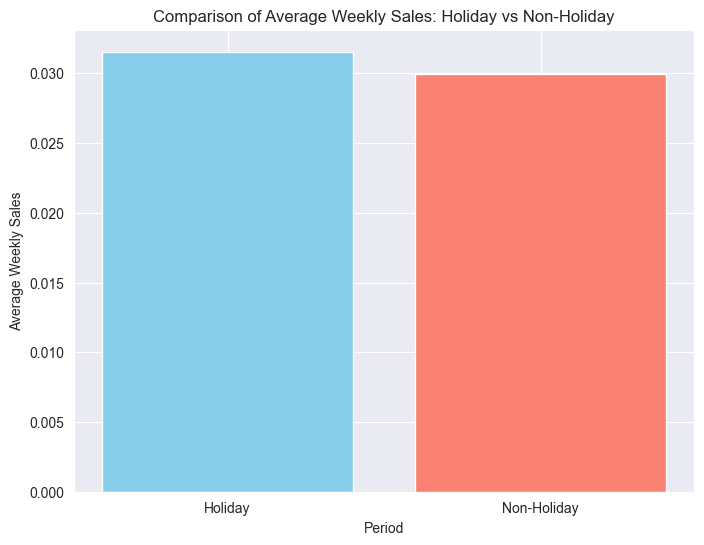

In [42]:
import matplotlib.pyplot as plt

# Calculate average sales for holidays and non-holidays
average_sales = {
    'Holiday': holiday_sales.mean(),
    'Non-Holiday': non_holiday_sales.mean()
}

# Plot bar chart
plt.figure(figsize=(8, 6))
plt.bar(average_sales.keys(), average_sales.values(), color=['skyblue', 'salmon'])
plt.xlabel("Period")
plt.ylabel("Average Weekly Sales")
plt.title("Comparison of Average Weekly Sales: Holiday vs Non-Holiday")
plt.show()
